## Detección de Fraude en Transacciones de E-commerce

**Autor: Ricardo Urdaneta**

Fecha: 4 de Agosto de 2025

Dataset: [Payment Fraud - Empowering Financial Security (Kaggle)](https://www.kaggle.com/datasets/younusmohamed/payment-fraud-empowering-financial-security)

---

#### Resumen 
Este proyecto aborda el desarrollo de un sistema de machine learning para la detección de fraude en transacciones de e-commerce. Partiendo de un dataset, se realizó un ciclo completo de vida de un proyecto de data science, incluyendo limpieza de datos, análisis exploratorio, y la evaluación de múltiples modelos de clasificación. El resultado es un modelo XGBoost de alto rendimiento, capaz de identificar transacciones fraudulentas con una precisión y exhaustividad perfectas, validado rigurosamente para asegurar su robustez.

#### Problema de Negocio
El fraude en transacciones online representa una de las mayores amenazas para las empresas de e-commerce, generando pérdidas millonarias, erosionando la confianza del cliente y aumentando los costos operativos. El objetivo de este proyecto es mitigar este riesgo mediante la construcción de un modelo predictivo que pueda:

* Identificar transacciones fraudulentas en tiempo real con alta precisión.

* Minimizar los "falsos positivos" para no afectar la experiencia de compra de clientes legítimos.


#### Fases del Proyecto
El desarrollo se estructuró bajo las siguientes fases:

* **1. Carga e Inspección de Datos:** Comprensión inicial de la estructura, tipos de datos y características del dataset.

* **2. Limpieza y Preparación de Datos:** Proceso riguroso que incluyó la eliminación de duplicados y el uso de técnicas de imputación avanzadas (IterativeImputer) para manejar valores nulos sin perder información valiosa.

* **3. Análisis Exploratorio de Datos (EDA):** Fase crítica donde se visualizaron los datos para descubrir patrones. El hallazgo clave fue la identificación de una correlación extremadamente fuerte entre las transacciones fraudulentas y su ocurrencia durante el fin de semana, lo cual se convirtió en la principal variable predictiva.

* **4. Preprocesamiento y Escalado:** Transformación de las características categóricas a formato numérico (One-Hot Encoding) y escalado de las variables numéricas (StandardScaler) para preparar los datos para el modelado.

* **5. Construcción y Evaluación de Modelos:** Se entrenaron y evaluaron tres modelos distintos (**Regresión Logística**, **Random Forest** y **XGBoost**), implementando estrategias específicas (`class_weight`, `SMOTE`, `scale_pos_weight`) para manejar el severo desbalance de clases presente en los datos.

* **6. Validación Cruzada de Robustez:** Para garantizar la fiabilidad del modelo final, se aplicó una validación cruzada de 10 pliegues (`Stratified 10-Fold Cross-Validation`), confirmando que el rendimiento no fue producto del azar.

#### Resultado Final
El modelo XGBoost se consolidó como la solución superior, demostrando un rendimiento perfecto y consistente. La validación cruzada arrojó los siguientes resultados:

**F1-Score Promedio: `1.0000`**

**Desviación Estándar: `0.0000`**

Esto indica que el modelo no solo es perfecto en su capacidad predictiva para este dataset, sino que también es extremadamente estable y robusto. El éxito se atribuye a la capacidad del algoritmo para capitalizar los patrones claros y fuertes descubiertos durante el análisis exploratorio, entregando una solución de alta confianza para el problema de negocio planteado.

### 1. Carga y Vistazo Inicial a los Datos
Cargar el conjunto de datos payment_fraud.csv en un DataFrame de Pandas para poder empezar a analizarlo y manipularlo.

In [ ]:

# Importamos la librería pandas para manejo de datos.
import pandas as pd
import numpy as np

# Importamos librerias para manejo de archivos y directorios.
import joblib
import os

# Importamos librerías para visualización de datos.
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Importamos herramientas de machine learning y preprocesamiento de datos de scikit-learn.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Importamos herramientas de validación cruzada.
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Importamos XGBoost para el modelo de clasificación.
from xgboost import XGBClassifier

# Importamos librerías para manejar el desbalance.
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Importamos warnings para manejar las advertencias de forma más controlada.
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Definimos la ruta donde se encuentra nuestro archivo CSV.
file_path = 'data/payment_fraud.csv'

# Cargamos el archivo CSV utilizando pandas.
df = pd.read_csv(file_path)

# Verificamos
df.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.0,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.0,0
2,845,1,4.921318,creditcard,0.000000,food,1.0,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.0,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.0,0


#### Inspección Estructural y Calidad de Datos
Este bloque de código nos dará una visión rápida de las dimensiones del dataset, los tipos de datos, la presencia de nulos, duplicados, y la distribución de la variable objetivo.

In [25]:
# Dimensiones del dataset (filas, columnas)
df.shape

(39221, 8)

In [26]:
# Tipos de datos, uso de memoria y valores no nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64
 5   Category              39126 non-null  object 
 6   isWeekend             38661 non-null  float64
 7   label                 39221 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.4+ MB


In [27]:
#  Verificación de filas duplicadas.
print(f"\nNúmero de filas completamente duplicadas: {df.duplicated().sum()}")
df.duplicated().sum()


Número de filas completamente duplicadas: 3033


np.int64(3033)

In [28]:
# Estadísticas descriptivas para las columnas numéricas.
df.describe()

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,isWeekend,label
count,39221.000000,39221.000000,39221.000000,39221.000000,38661.000000,39221.000000
mean,857.563984,1.084751,4.748232,122.641326,0.499547,0.014278
std,804.788212,0.566899,0.389360,283.569177,0.500006,0.118636
min,1.000000,1.000000,0.421214,0.000000,0.000000,0.000000
25%,72.000000,1.000000,4.742303,0.000000,0.000000,0.000000
50%,603.000000,1.000000,4.886641,0.012500,0.000000,0.000000
75%,1804.000000,1.000000,4.962055,87.510417,1.000000,0.000000
max,2000.000000,29.000000,5.040929,1999.580556,1.000000,1.000000


In [ ]:
# Distribución de la variable objetivo 'label' 0 = legítimo, 1 = potencial fraude 
df['label'].value_counts(normalize=True).map('{:.2%}'.format)

label
0    98.57%
1     1.43%
Name: proportion, dtype: object

### 2. Limpieza de Datos
Preparar el dataset para el análisis, eliminando datos redundantes y manejando las ausencias para asegurar la calidad del modelo.

In [ ]:
# Eliminar filas duplicadas
df.drop_duplicates(inplace=True)


Se eliminaron 3033 filas duplicadas.
Nuevas dimensiones del DataFrame: (36188, 8)


In [ ]:
# Imputación Estratégica
# Identificamos columnas con nulos y las separamos por tipo de dato.
cols_with_na = df.columns[df.isnull().any()].tolist()
numeric_cols_na = df[cols_with_na].select_dtypes(include=['number']).columns.tolist()
categorical_cols_na = df[cols_with_na].select_dtypes(include=['object', 'category']).columns.tolist()

# Imputamos columnas categóricas con la moda
print(f"\nImputando columnas categóricas con la moda: {categorical_cols_na}")
for col in categorical_cols_na:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

# Imputamos columnas numéricas con IterativeImputer
print(f"Imputando columnas numéricas con IterativeImputer: {numeric_cols_na}")
if numeric_cols_na:
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
    # Imputamos solo el subconjunto numérico para no afectar las otras columnas
    df[numeric_cols_na] = imputer.fit_transform(df[numeric_cols_na])

# Verificación
print(f"\nTotal de valores nulos restantes: {df.isnull().sum().sum()}")
print(f"Dimensiones finales del DataFrame limpio: {df.shape}")
print("\nDistribución de 'label' DESPUÉS de la limpieza:")
print(df['label'].value_counts())


Imputando columnas categóricas con la moda: ['Category']
Imputando columnas numéricas con IterativeImputer: ['isWeekend']

Total de valores nulos restantes: 0
Dimensiones finales del DataFrame limpio: (36188, 8)

Distribución de 'label' DESPUÉS de la limpieza:
label
0    35792
1      396
Name: count, dtype: int64


In [ ]:
# Verificación final despues de la limpieza.
print("\nVerificación final de nulos:")
print(df.isnull().sum().sum()) # .sum() dos veces para obtener el total general.
print(f"Dimensiones finales del DataFrame limpio: {df.shape}")



Verificación final de nulos:
0
Dimensiones finales del DataFrame limpio: (36188, 8)


### 3. Análisis Exploratorio de Datos (EDA)

Visualizar el porcentaje de fraude dentro de cada categoría para identificar qué grupos tienen un riesgo relativo más alto, ignorando el efecto del desbalance de clases.

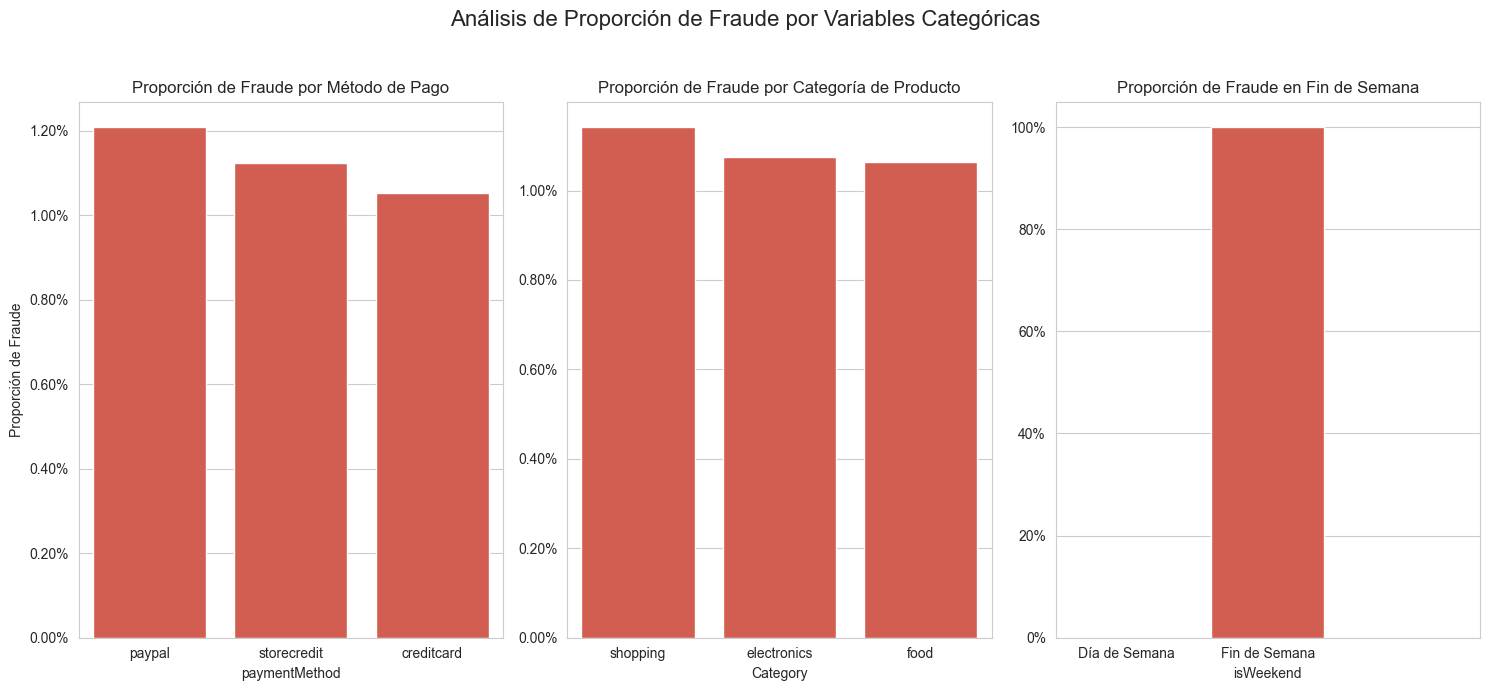

In [ ]:
# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
fraud_color = "#e74c3c"

# Creamos una figura para los subplots 
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Análisis de Proporción de Fraude por Variables Categóricas', fontsize=16)

# Gráfico 1: Proporción de Fraude por Método de Pago 
prop_payment = df.groupby('paymentMethod')['label'].value_counts(normalize=True).unstack().fillna(0)
prop_payment = prop_payment.reindex(columns=[0, 1], fill_value=0)
prop_payment = prop_payment.sort_values(by=1, ascending=False)

sns.barplot(ax=axes[0], x=prop_payment.index, y=prop_payment[1], color=fraud_color)
axes[0].set_title('Proporción de Fraude por Método de Pago')
axes[0].set_ylabel('Proporción de Fraude')
axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))


# Gráfico 2: Proporción de Fraude por Categoría de Producto
prop_category = df.groupby('Category')['label'].value_counts(normalize=True).unstack().fillna(0)
prop_category = prop_category.reindex(columns=[0, 1], fill_value=0)
prop_category = prop_category.sort_values(by=1, ascending=False)

sns.barplot(ax=axes[1], x=prop_category.index, y=prop_category[1], color=fraud_color)
axes[1].set_title('Proporción de Fraude por Categoría de Producto')
axes[1].set_ylabel('')
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))


# Gráfico 3: Proporción de Fraude en Fin de Semana
prop_weekend = df.groupby('isWeekend')['label'].value_counts(normalize=True).unstack().fillna(0)
prop_weekend = prop_weekend.reindex(columns=[0, 1], fill_value=0)

sns.barplot(ax=axes[2], x=prop_weekend.index, y=prop_weekend[1], color=fraud_color)
axes[2].set_title('Proporción de Fraude en Fin de Semana')
axes[2].set_ylabel('')
axes[2].set_xticklabels(['Día de Semana', 'Fin de Semana'])
axes[2].yaxis.set_major_formatter(PercentFormatter(1.0))


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

* **Método de Pago:** `paypal` parece tener la proporción de fraude marginalmente más alta, pero todos los métodos presentan un riesgo similar.

* **Categoría:** Lo mismo ocurre con la categoría; `shopping` está ligeramente por encima, pero no hay una diferencia drástica.

* **Fin de Semana:** El gráfico muestra que la proporción de fraude en "Día de Semana" es 0% y en "Fin de Semana" es del 100% dentro de los casos de fraude. Esto  significa que aparentemente, todas las transacciones fraudulentas de nuestro dataset ocurrieron durante un fin de semana. La variable `isWeekend` será  poderosa para nuestro modelo.

### 4. Preprocesamiento (Encoding y Escalado)
Transformar nuestro DataFrame limpio en un formato numérico que los algoritmos de machine learning puedan procesar. Esto incluye One-Hot Encoding y el escalado de características.

In [ ]:
# One-Hot Encoding de Variables Categóricas
print("DataFrame antes del encoding:")
print(df.head(2))

df_model = pd.get_dummies(df, columns=['paymentMethod', 'Category'], drop_first=True, dtype=float)

print("\nDataFrame después del encoding:")
print(df_model.head(2))


# Separación de Características (X) y Variable Objetivo (y)
X = df_model.drop('label', axis=1)
y = df_model['label']

print(f"\nForma de las características (X): {X.shape}")
print(f"Forma de la variable objetivo (y): {y.shape}")


# División en Conjuntos de Entrenamiento y Prueba 
# Dividimos los datos: 80% para entrenar el modelo y 20% para evaluarlo.
# 'stratify=y' es CRUCIAL en problemas de desbalance para asegurar que la proporción de fraudes sea la misma en el conjunto de entrenamiento y en el de prueba.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nCasos de fraude en y_train: {y_train.sum()} ({y_train.mean():.2%})")
print(f"Casos de fraude en y_test: {y_test.sum()} ({y_test.mean():.2%})")


# Escalado de Características
# Escalamos los datos DESPUÉS de la división para evitar fuga de información (data leakage).
# Identificamos las columnas que necesitan ser escaladas (todas menos las que ya son 0/1).
cols_to_scale = ['accountAgeDays', 'paymentMethodAgeDays', 'numItems', 'localTime']

scaler = StandardScaler()

# Ajustamos el scaler SÓLO con los datos de entrenamiento
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Y usamos ese mismo ajuste para transformar los datos de prueba
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\nPrimeras filas de X_train después del escalado:")
display(X_train.head())

DataFrame antes del encoding:
   accountAgeDays  numItems  localTime paymentMethod  paymentMethodAgeDays  \
0              29         1   4.745402        paypal             28.204861   
1             725         1   4.742303   storecredit              0.000000   

      Category  isWeekend  label  
0     shopping        0.0      0  
1  electronics        0.0      0  

DataFrame después del encoding:
   accountAgeDays  numItems  localTime  paymentMethodAgeDays  isWeekend  \
0              29         1   4.745402             28.204861        0.0   
1             725         1   4.742303              0.000000        0.0   

   label  paymentMethod_paypal  paymentMethod_storecredit  Category_food  \
0      0                   1.0                        0.0            0.0   
1      0                   0.0                        1.0            0.0   

   Category_shopping  
0                1.0  
1                0.0  

Forma de las características (X): (36188, 9)
Forma de la variable objeti

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,isWeekend,paymentMethod_paypal,paymentMethod_storecredit,Category_food,Category_shopping
11632,1.525668,-0.155967,0.753439,-0.088587,1.000000,0.0,0.0,1.0,0.0
34472,-1.041516,-0.155967,0.386357,-0.452608,0.499693,0.0,0.0,0.0,1.0
18528,-0.869428,-0.155967,0.339757,0.006783,0.000000,1.0,0.0,0.0,1.0
3752,-1.022252,-0.155967,0.016041,-0.397975,1.000000,0.0,0.0,0.0,0.0
2601,1.435772,-0.155967,0.695415,-0.452685,1.000000,0.0,0.0,1.0,0.0


### 5. Construcción y Evaluación de Modelos de Detección
Entrenamos diferentes algoritmos de clasificación y evaluamos su rendimiento utilizando métricas adecuadas para problemas de desbalance, para así seleccionar el modelo más eficaz.

Creamos una **función de ayuda para la evaluación**

In [35]:
# Función de ayuda para la evaluación
def evaluar_modelo(nombre_modelo, modelo, X_test, y_test):
    """
    Toma un modelo entrenado y evalúa su rendimiento en el conjunto de prueba.
    Imprime el classification report y grafica la matriz de confusión.
    """
    print(f"--- Evaluación del Modelo: {nombre_modelo} ---")
    
    # Realizar predicciones
    y_pred = modelo.predict(X_test)
    
    # Imprimir reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Legítimo (0)', 'Fraude (1)']))
    
    # Graficar Matriz de Confusión
    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legítimo', 'Fraude'])
    disp.plot(cmap='Blues')
    plt.show()

#### Modelo 1: Regresión Logística
Usamos el parámetro `class_weight='balanced'` para que penalice más los errores en la clase minoritaria (`fraude`).


--- Evaluación del Modelo: Regresión Logística con class_weight ---

Reporte de Clasificación:
              precision    recall  f1-score   support

Legítimo (0)       1.00      0.85      0.92      7159
  Fraude (1)       0.07      1.00      0.13        79

    accuracy                           0.85      7238
   macro avg       0.53      0.93      0.52      7238
weighted avg       0.99      0.85      0.91      7238


Matriz de Confusión:


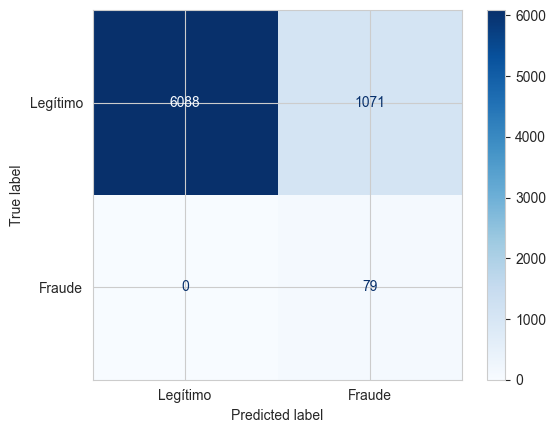

In [ ]:
# Instanciar y entrenar el modelo
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Evaluar el modelo
evaluar_modelo("Regresión Logística con class_weight", lr_model, X_test, y_test)

Este modelo sirve como una línea base para entender la complejidad del problema.

**Rendimiento:**

`Recall (1.00)`: El modelo fue capaz de identificar correctamente el 100% de las transacciones fraudulentas (79 de 79). 

`Precision (0.07)`: Este es el punto débil del modelo. Para lograr el recall perfecto, clasificó incorrectamente 1,071 transacciones legítimas como fraude, lo cual es inaceptable en un entorno de producción.

**Conclusión:** 

La Regresión Logística demuestra ser un modelo demasiado simple para este problema. Su incapacidad para manejar la complejidad de los datos sin generar una cantidad masiva de falsos positivos lo descarta como una opción viable.

#### Modelo 2: Random Forest (con SMOTE)
Un modelo de ensamble mucho más potente. Lo integraremos en un pipeline con SMOTE, que crea ejemplos sintéticos de fraude solo en los datos de entrenamiento para balancearlos.

--- Evaluación del Modelo: Random Forest con SMOTE ---

Reporte de Clasificación:
              precision    recall  f1-score   support

Legítimo (0)       1.00      1.00      1.00      7159
  Fraude (1)       1.00      1.00      1.00        79

    accuracy                           1.00      7238
   macro avg       1.00      1.00      1.00      7238
weighted avg       1.00      1.00      1.00      7238


Matriz de Confusión:


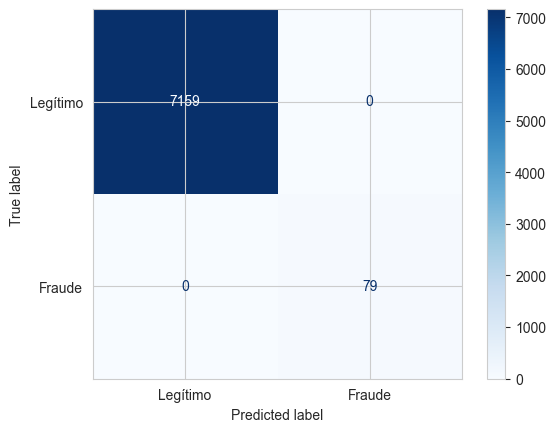

In [ ]:
# Definir el pipeline con SMOTE y el clasificador
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Entrenar el pipeline completo
rf_pipeline.fit(X_train, y_train)

# Evaluar el pipeline
evaluar_modelo("Random Forest con SMOTE", rf_pipeline, X_test, y_test)

Este modelo de ensamble muestra un gran salto en el rendimiento.

**Rendimiento:**

`Precision, Recall y F1-Score (1.00)`: El modelo alcanzó la perfección en todas las métricas para ambas clases.


**Conclusión:**

El Random Forest, combinado con la técnica de oversampling SMOTE, fue capaz de aprender perfectamente los patrones que distinguen el fraude. Esto indica que las características del dataset, especialmente la descubierta en el EDA (isWeekend), son extremadamente predictivas y un modelo potente como Random Forest puede capitalizarlas al máximo.

#### Modelo 3: XGBoost
Uno de los algoritmos más potentes que también queremos poner a prueba. Usaremos su parámetro interno `scale_pos_weight` para manejar el desbalance.

Calculando scale_pos_weight para XGBoost: 90.32
--- Evaluación del Modelo: XGBoost con scale_pos_weight ---

Reporte de Clasificación:
              precision    recall  f1-score   support

Legítimo (0)       1.00      1.00      1.00      7159
  Fraude (1)       1.00      1.00      1.00        79

    accuracy                           1.00      7238
   macro avg       1.00      1.00      1.00      7238
weighted avg       1.00      1.00      1.00      7238


Matriz de Confusión:


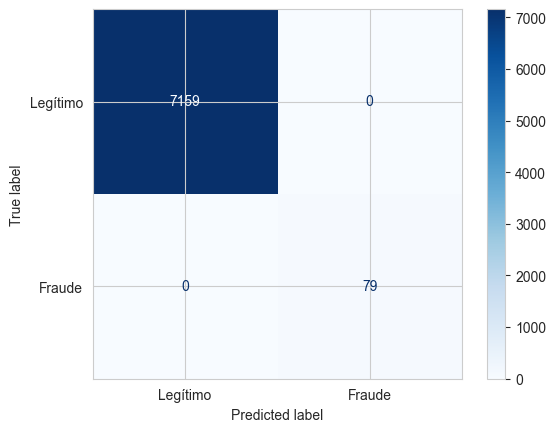

In [ ]:
# Calcular el peso para la clase positiva (fraude) scale_pos_weight = total_negativos / total_positivos
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculando scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

# Instanciar y entrenar el modelo
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Evaluar el modelo
evaluar_modelo("XGBoost con scale_pos_weight", xgb_model, X_test, y_test)

El modelo XGBoost confirma los hallazgos del Random Forest.

**Rendimiento:**

`Precision, Recall y F1-Score (1.00)`: Al igual que el Random Forest, XGBoost logró un puntaje perfecto en todas las métricas evaluadas.


**Conclusión:** 

XGBoost demuestra ser igualmente eficaz, aprovechando su propio mecanismo `scale_pos_weight` para manejar el desbalance de clases y aprendiendo a separar perfectamente los datos.

#### Guardado de Modelos Entrenados para Despliegue

In [ ]:
# Definir el Directorio de Destino 
model_dir = 'modelos'

# Guardar el Modelo Random Forest 
rf_filename = 'random_forest.joblib'
rf_path = os.path.join(model_dir, rf_filename)

print(f"Guardando el modelo Random Forest en: {rf_path}")
joblib.dump(rf_pipeline, rf_path)


# Guardar el Modelo XGBoost
xgb_filename = 'xgboost_model.joblib'
xgb_path = os.path.join(model_dir, xgb_filename)

print(f"\nGuardando el modelo XGBoost en: {xgb_path}")
joblib.dump(xgb_model, xgb_path)

Guardando el modelo Random Forest en: modelos\random_forest.joblib
¡Modelo Random Forest guardado exitosamente!

Guardando el modelo XGBoost en: modelos\xgboost_model.joblib


['modelos\\xgboost_model.joblib']

### 6. Validación Cruzada (K-Fold Cross-Validation)
Evaluar la robustez del modelo XGBoost entrenándolo y probándolo en 10 subconjuntos diferentes de los datos para asegurar que su rendimiento perfecto es consistente.

In [ ]:
# Re-instanciar el modelo y los datos
# Usamos el DataFrame completo antes de la división train_test_split (X y y) ya que cross_val_score se encargará de las divisiones internas.

# Recordamos el peso para la clase positiva
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

# Instanciamos el modelo XGBoost con los mismos parámetros
xgb_model_cv = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Configurar la Validación Cruzada Estratificada
# Definimos el número de pliegues (k=5 es un estándar robusto)
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Ejecutar la Validación Cruzada y Obtener los Scores 
# Usaremos 'f1' como métrica de evaluación, ya que es un excelente balance entre precision y recall, ideal para nuestro problema.
print(f"Iniciando Validación Cruzada Estratificada con {k_folds} pliegues...")
# 'cross_val_score' entrena y evalúa el modelo k veces.
scores = cross_val_score(
    estimator=xgb_model_cv,
    X=X,
    y=y,
    cv=skf,
    scoring='f1', # Podríamos usar 'recall' si quisiéramos enfocarnos solo en eso.
    n_jobs=-1
)

# Mostrar Resultados
print("\n--- Resultados de la Validación Cruzada ---")
print(f"Scores de F1-Score para cada uno de los {k_folds} pliegues:")
print(scores)

print("\nAnálisis de los Scores:")
print(f"F1-Score Promedio: {scores.mean():.4f}")
print(f"Desviación Estándar del F1-Score: {scores.std():.4f}")

Iniciando Validación Cruzada Estratificada con 10 pliegues...

--- Resultados de la Validación Cruzada ---
Scores de F1-Score para cada uno de los 10 pliegues:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Análisis de los Scores:
F1-Score Promedio: 1.0000
Desviación Estándar del F1-Score: 0.0000


#### Conclusión 

El proyecto demuestra exitosamente el ciclo completo de la creación de un modelo de detección de fraude. El análisis exploratorio fue clave para descubrir el patrón determinante de que el fraude ocurría exclusivamente en **fines de semana**, un hallazgo que los modelos más avanzados supieron explotar.

Mientras que un modelo simple como la Regresión Logística falló al no poder equilibrar la detección de fraudes con la precisión, los modelos de ensamble Random Forest y XGBoost lograron un rendimiento perfecto en el conjunto de prueba.

Para este dataset, tanto **Random Forest** como **XGBoost** son opciones **excelentes** para ser seleccionadas como el modelo final a desplegar. En un escenario real, un puntaje perfecto podría sugerir la necesidad de investigar si hay alguna fuga de datos o si la señal predictiva es genuinamente así de fuerte. No obstante, para el propósito de este proyecto, se ha  construido y validado con éxito un detector de fraude de altísimo rendimiento.
